## Text Classification- Consumer Complaints

### Abstract

Text data is a common form of unstructured data and getting meaningful insights from text data can be difficult. Supervised machine learning algorithms can be used to classify text documents using Natural Language Processing techniques. Text classification involves trying to organize text documents into various categories based on inherent properties or attributes of the text document. Here we are trying to determine which product class the text documents belong.We will have trained text classification model at the end of the project.

### Problem Statement

A large amount of data is generated via the SDK Bank's consumer complaints tool. Each complaint has a narrative which can be used to categorize it’s relation to bank's product. Currently complaints are classified by support specialists. Classifying the complaints will  allow redirecting the complaints to the correct department as soon as complaints are logged. The classified complaints will be verified by the departments before processing. A text classifier can provide immediate cost savings, better SLA and more accurate predictions than a human counterpart. Improved customer satisfaction and improved efficiency of common workflows are major outcomes


### Objective

The objective of this project is to classify the consumer complaints by product category using Supervised Machine Learning techniques. Mortgage and Debt Collection are the two products classes selected for Text classification.


In [159]:
!python --version

Python 3.6.13 :: Anaconda, Inc.


In [160]:
#all libraries
import pandas as pd
import re #text preprocessing and wrangling
import os
import spacy
import matplotlib.pyplot as plt
pd.options.display.max_colwidth =1000
#os.getcwd()

### Read Data

In [161]:
raw=pd.read_csv("complaints-2021.csv",parse_dates=['Date received','Date sent to company'])

In [162]:
#rename columns
names=['recieved_date','product','subproduct','issue','subissue','consumer_complaint_narrative','company_response_public','company','state','zipcode','tags','consumer_consent_provided','submit_mode','senttocompany_date','company_response_consumer','timely_response','consumer_disputed','id']
raw.columns=names

In [163]:
# adding new features

#narrative length
raw['narrative_len'] = raw['consumer_complaint_narrative'].astype(str).apply(len)

#narrative word count
raw['narrative_word_count'] = raw['consumer_complaint_narrative'].apply(lambda x: len(str(x).split()))

### Dataset Description

In [164]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5233 entries, 0 to 5232
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   recieved_date                 5233 non-null   datetime64[ns]
 1   product                       5233 non-null   object        
 2   subproduct                    5233 non-null   object        
 3   issue                         5233 non-null   object        
 4   subissue                      5233 non-null   object        
 5   consumer_complaint_narrative  5233 non-null   object        
 6   company_response_public       5233 non-null   object        
 7   company                       5233 non-null   object        
 8   state                         5233 non-null   object        
 9   zipcode                       5233 non-null   object        
 10  tags                          5233 non-null   object        
 11  consumer_consent_provided     

### Exploratory Analysis

In [165]:
raw.groupby(["company", "product"])["id"].count().sort_values(ascending=False)

company                                   product        
Shellpoint Partners, LLC                  Mortgage           164
WELLS FARGO & COMPANY                     Mortgage           128
LoanCare, LLC                             Mortgage           122
I.C. System, Inc.                         Debt collection    120
AMERISAVE MORTGAGE CORPORATION            Mortgage           113
                                                            ... 
Fairway Independent Mortgage Corporation  Debt collection      1
                                          Mortgage             1
Peroutka, Miller, Klima & Peters, P.A.    Debt collection      1
Fein, Such, Kahn & Shepard, P.C.          Debt collection      1
KMD Partners, LLC                         Debt collection      1
Name: id, Length: 851, dtype: int64

In [166]:
#drop rows narrative length greater 5K

raw=raw[raw['narrative_len']<5000]
raw.reset_index(drop=True)

,recieved_date,product,subproduct,issue,subissue,consumer_complaint_narrative,company_response_public,company,state,zipcode,tags,consumer_consent_provided,submit_mode,senttocompany_date,company_response_consumer,timely_response,consumer_disputed,id,narrative_len,narrative_word_count
0,2021-01-30,Debt collection,Federal student loan debt,Threatened to contact someone or share information improperly,Contacted your employer,"I received a letter dated XX/XX/XXXX, stating that my Federal loan debt ( approximately XXXX ) was taken over by another company after the initial company, Conserv/Ascendium in conjunction with XXXX XXXX XXXX XXXX, conducted a financial review/administrative hearing to determine if and what I could pay on the past loans. I never received any resolution from Conserv/ECMC but the next time I heard anything about my loans was when I was contacted with a letter from the new company, NES, or National Enterprise System. Again, I did not receive a determination letter or a conclusion to this initial review but rather, was contacted by a new collector named, National Enterprise System ( NES ). I contacted ( via phone call XXXX ext.XXXX ) NES and was routed to a XXXX XXXX XXXX manager ext.XXXX ). According to the letter his department sent me and Mr. XXXX admissions on the first phone call, I had three options one of which was the ability to rehabilitate my loans with XXXX ( a federal loan ...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"National Enterprise Systems, Inc.",SC,294XX,None,Consent provided,Web,2021-01-30,Closed with explanation,Yes,NaN,4106105,3609,633
1,2021-01-20,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,"Bonneville debt collection has called twice ( about a week ago and today XX/XX/2021 ) leaving a message but no detail other than a callback number. I don't have any unpaid debts and when trying to call the number they provide, you just sit on hold in a queue for over an hour. No one answers. Considering this isn't my debt, this is harassment.",None,Bonneville Billing and Collections,WA,986XX,Servicemember,Consent provided,Web,2021-01-20,Closed with explanation,Yes,NaN,4081174,344,64
2,2021-01-15,Debt collection,Medical debt,Written notification about debt,Didn't receive enough information to verify debt,"I sent a certified verification of debt letter to the Medical Business Bureau. Unfortunately, the bureau failed to provide any documentation with my signature verifying this debt. I can not pay and will not pay anything that can not be verified. I requested detailed documentaion and the Bureau could not proivde this info.",None,Medical Business Bureau,IL,606XX,None,Consent provided,Web,2021-01-15,Closed with explanation,Yes,NaN,4071675,323,53
3,2021-01-30,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,"Starting around XX/XX/XXXX, I receive a call every day around XXXX XXXX ( except maybe Sunday XXXX from phone number XXXX. I have not answered. Today, XX/XX/XXXX, I inadvertently called the number. I was trying to get the complete phone number so I could file this complaint. \n\nI heard a recorded voice that gave an amount owed, a notice of a convenience fee for collecting payment, and a website : sequium.com. There is no collection account information on my credit report, I've received nothing in the mail, and any collection debt in the past is paid and is at least twenty years old.",Company believes it acted appropriately as authorized by contract or law,"Sequium Asset Solutions, LLC",PA,15009,None,Consent provided,Web,2021-01-30,Closed with explanation,Yes,NaN,4105089,588,103
4,2021-01-19,Mortgage,Conventional home mortgage,Trouble during payment process,None,"Background : New Res Shellpoint Mtg took over the mortgage servicing of our loan from XXXX XXXX XXXX when we file for Chapter XXXX Bankruptcy protection on XX/XX/XXXX. We were behind on payments and included them in our

In [167]:
#drop rows narrative length greater 5K

raw=raw[raw['narrative_word_count']<500]
raw.reset_index(drop=True)

,recieved_date,product,subproduct,issue,subissue,consumer_complaint_narrative,company_response_public,company,state,zipcode,tags,consumer_consent_provided,submit_mode,senttocompany_date,company_response_consumer,timely_response,consumer_disputed,id,narrative_len,narrative_word_count
0,2021-01-20,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,"Bonneville debt collection has called twice ( about a week ago and today XX/XX/2021 ) leaving a message but no detail other than a callback number. I don't have any unpaid debts and when trying to call the number they provide, you just sit on hold in a queue for over an hour. No one answers. Considering this isn't my debt, this is harassment.",None,Bonneville Billing and Collections,WA,986XX,Servicemember,Consent provided,Web,2021-01-20,Closed with explanation,Yes,NaN,4081174,344,64
1,2021-01-15,Debt collection,Medical debt,Written notification about debt,Didn't receive enough information to verify debt,"I sent a certified verification of debt letter to the Medical Business Bureau. Unfortunately, the bureau failed to provide any documentation with my signature verifying this debt. I can not pay and will not pay anything that can not be verified. I requested detailed documentaion and the Bureau could not proivde this info.",None,Medical Business Bureau,IL,606XX,None,Consent provided,Web,2021-01-15,Closed with explanation,Yes,NaN,4071675,323,53
2,2021-01-30,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,"Starting around XX/XX/XXXX, I receive a call every day around XXXX XXXX ( except maybe Sunday XXXX from phone number XXXX. I have not answered. Today, XX/XX/XXXX, I inadvertently called the number. I was trying to get the complete phone number so I could file this complaint. \n\nI heard a recorded voice that gave an amount owed, a notice of a convenience fee for collecting payment, and a website : sequium.com. There is no collection account information on my credit report, I've received nothing in the mail, and any collection debt in the past is paid and is at least twenty years old.",Company believes it acted appropriately as authorized by contract or law,"Sequium Asset Solutions, LLC",PA,15009,None,Consent provided,Web,2021-01-30,Closed with explanation,Yes,NaN,4105089,588,103
3,2021-01-19,Mortgage,Conventional home mortgage,Trouble during payment process,None,"Background : New Res Shellpoint Mtg took over the mortgage servicing of our loan from XXXX XXXX XXXX when we file for Chapter XXXX Bankruptcy protection on XX/XX/XXXX. We were behind on payments and included them in our plan. \n\nWhen the loan was transferred from XXXX XXXX XXXX to Shellpoint on XX/XX/XXXX. Either XXXX XXXX XXXX or Shellpoint didn't record our payment of {$3500.00} which was paid on XX/XX/XXXX electronically posted according to XXXX XXXX. \n\nThis threw our payment history off for years. Until Congress passed the Morgage Servicing Act in April of 2018, I was unaware there was an issue. \n\nFinally after years and having to retain an attorney, Shellpoint found the payment. After weeks on end of calling, emailing, and being placed on hold. \n\nMy Chapter XXXX Bankruptcy was discharged, XX/XX/XXXX Problem # 1, The Shellpoint Statements have been misstated since they began serving the loan. This affects our ability to provide documentation in order to refinance our l...",Company believes the complaint provided an opportunity to answer consumer's questions,"Shellpoint Partners, LLC",MD,None,Older American,Consent provided,Web,2021-01-19,Closed with explanation,Yes,NaN,4078139,2595,436
4,2021-01-11,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt is not yours,"I have recently reviewed a copy of my credit report. I ( Consumer, XXXX XXXX ) notice that there are several inaccuraries on my report that I didn't authorize =. These accounts are violating my rights according to the FDCPA. The Credit Reporting agency continues to violate 

In [168]:
#count by product type
raw['product'].value_counts()

Debt collection    3193
Mortgage           1637
Name: product, dtype: int64

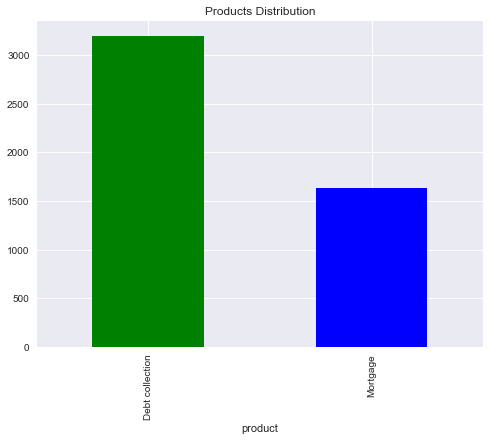

In [169]:
fig = plt.figure(figsize=(8,6))
raw.groupby('product').consumer_complaint_narrative.count().plot.bar(ylim=0,color=['green','blue'])
plt.title('Products Distribution')
plt.show()

In [170]:
#count by state
raw["state"].value_counts()

CA                                      584
TX                                      542
FL                                      509
GA                                      337
NY                                      209
PA                                      200
NJ                                      167
IL                                      167
MD                                      139
AZ                                      128
MA                                      123
NC                                      119
VA                                      117
MI                                      115
OH                                      104
TN                                       93
MO                                       90
AL                                       90
WA                                       81
NV                                       79
SC                                       76
CO                                       71
WI                              

In [171]:
#conda install -c anaconda seaborn

Text(0.5, 1.0, 'Top 10 states by complaints')

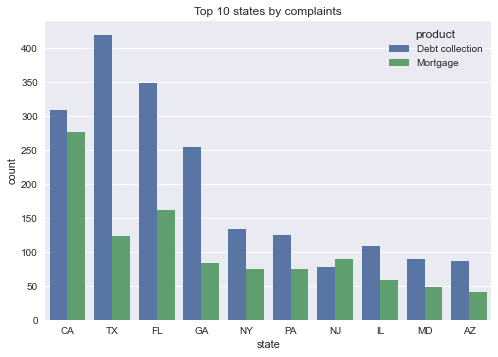

In [172]:
#State wise distribution

import seaborn as sns
sns.countplot(data=raw,x='state',hue='product',order=raw.state.value_counts().iloc[:10].index).set_title("Top 10 states by complaints")



Text(0.5, 1.0, 'Complaints by Date')

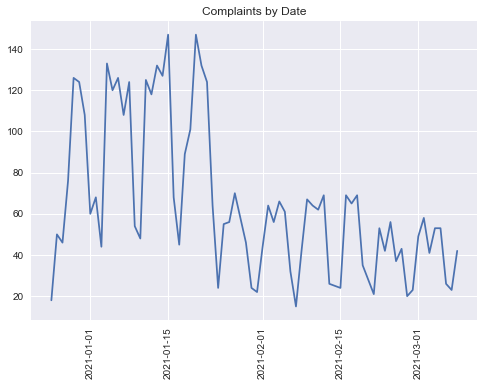

In [173]:
cnt =raw.groupby('recieved_date').size().rename('Count')
result = raw.drop_duplicates(subset='recieved_date')\
    .merge(cnt, left_on='recieved_date', right_index=True)
result = result.sort_values('recieved_date', ascending=True)
plt.plot(result['recieved_date'], result['Count'])
plt.xticks(rotation='vertical')
plt.title('Complaints by Date')

### Text Preprocessing

In [174]:
#dataframe for text classification

complaints=raw.loc[:,['product','consumer_complaint_narrative']]
complaints.head()

,product,consumer_complaint_narrative
1,Debt collection,"Bonneville debt collection has called twice ( about a week ago and today XX/XX/2021 ) leaving a message but no detail other than a callback number. I don't have any unpaid debts and when trying to call the number they provide, you just sit on hold in a queue for over an hour. No one answers. Considering this isn't my debt, this is harassment."
2,Debt collection,"I sent a certified verification of debt letter to the Medical Business Bureau. Unfortunately, the bureau failed to provide any documentation with my signature verifying this debt. I can not pay and will not pay anything that can not be verified. I requested detailed documentaion and the Bureau could not proivde this info."
3,Debt collection,"Starting around XX/XX/XXXX, I receive a call every day around XXXX XXXX ( except maybe Sunday XXXX from phone number XXXX. I have not answered. Today, XX/XX/XXXX, I inadvertently called the number. I was trying to get the complete phone number so I could file this complaint. \n\nI heard a recorded voice that gave an amount owed, a notice of a convenience fee for collecting payment, and a website : sequium.com. There is no collection account information on my credit report, I've received nothing in the mail, and any collection debt in the past is paid and is at least twenty years old."
4,Mortgage,"Background : New Res Shellpoint Mtg took over the mortgage servicing of our loan from XXXX XXXX XXXX when we file for Chapter XXXX Bankruptcy protection on XX/XX/XXXX. We were behind on payments and included them in our plan. \n\nWhen the loan was transferred from XXXX XXXX XXXX to Shellpoint on XX/XX/XXXX. Either XXXX XXXX XXXX or Shellpoint didn't record our payment of {$3500.00} which was paid on XX/XX/XXXX electronically posted according to XXXX XXXX. \n\nThis threw our payment history off for years. Until Congress passed the Morgage Servicing Act in April of 2018, I was unaware there was an issue. \n\nFinally after years and having to retain an attorney, Shellpoint found the payment. After weeks on end of calling, emailing, and being placed on hold. \n\nMy Chapter XXXX Bankruptcy was discharged, XX/XX/XXXX Problem # 1, The Shellpoint Statements have been misstated since they began serving the loan. This affects our ability to provide documentation in order to refinance our l..."
5,Debt collection,"I have recently reviewed a copy of my credit report. I ( Consumer, XXXX XXXX ) notice that there are several inaccuraries on my report that I didn't authorize =. These accounts are violating my rights according to the FDCPA. The Credit Reporting agency continues to violate my rights according to 15 USC 1692d "" Any bad debt furnished on your reports is ruining your reputation and its defamation of character. '' I have attached my FTC report, License, and SSC."


In [175]:
complaints.isnull().sum()

product                         0
consumer_complaint_narrative    0
dtype: int64

### Expanding Contrcations

In [176]:
##Expanding Contractions

from contractions import CONTRACTION_MAP

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [177]:
#iterate through all the rows
for i, row in complaints.iterrows():
    complaints.at[i, 'narrative_expanded'] = expand_contractions(row.consumer_complaint_narrative)

### Accented Character Removal

In [178]:
#Remove Accented characters
import unicodedata
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [179]:
for i, row in complaints.iterrows():
    complaints.at[i, 'narrative_accented'] = remove_accented_chars(row.narrative_expanded)

### Entity Removal

In [180]:
# Entity Removal
nlp = spacy.load('en_core_web_sm')
def remove_entity(text_data):
    document = nlp(text_data)
    text_no_namedentities = []
    #print(type(text_no_namedentities))
    ents = [e.text for e in document.ents]
    for item in document:
        if item.text in ents:
            pass
        else:
            text_no_namedentities.append(item.text)
    return " ".join(text_no_namedentities)
        

In [181]:
for i, row in complaints.iterrows():
    complaints.at[i, 'narrative_entity'] = remove_entity(row.narrative_accented)

### Convert to Lowercase

In [182]:
#to lowercase
complaints['narrative_clean'] =complaints['narrative_entity'].apply(lambda x: ' '.join([i.lower() for i in x.split()]))

### String Cleaning

In [183]:
#clean function using regex

def clean(s):
    s= re.sub(r"[-}):,@\?\$%_({+"".=#!|&;*>'<`~]", "", s)
    s=re.sub(r'[xx/xx/xxxx]*', '', s)
    s=re.sub(r"\n",'', s)
    s = re.sub(r"\d", "", s)
    #s=re.sub(r"\b[a-zA-Z]\b", "", s)
    s= re.sub(r"\s+"," ", s)
    s=re.sub(r"^\s+", "", s)
    s=s.replace('""', "")
    s=s.replace("'", "")
    s=s.replace('"', '')
    s=re.sub(r"\s+[a-zA-Z]\s+", " ", s)
    s = re.sub(r"\With",'', s )
    #s=s.replace(r'[^\w\s]',"")
    #s=re.sub("\s\s+" , " ", s)
    return str(s)

In [184]:
#iterate through all the rows
for i, row in complaints.iterrows():
    complaints.at[i, 'narrative_clean'] = clean(row.narrative_clean)

In [185]:
#load spacy
nlp = spacy.load('en_core_web_sm')

#check pos and tags for sample text
test_sentence=complaints.iloc[0,5]
test_word=test_sentence.split()
spacy_pos_tagged = [(test_word, test_word.tag_, test_word.pos_) for test_word in nlp(test_sentence)]
pd.DataFrame(spacy_pos_tagged).T

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,debt,collection,has,called,twice,about,week,ago,and,leaving,...,answers,considering,this,is,not,my,debt,this,is,harassment
1,NN,NN,VBZ,VBN,RB,IN,NN,RB,CC,VBG,...,NNS,VBG,DT,VBZ,RB,PRP$,NN,DT,VBZ,NN
2,NOUN,NOUN,VERB,VERB,ADV,ADP,NOUN,ADV,CCONJ,VERB,...,NOUN,VERB,DET,VERB,ADV,ADJ,NOUN,DET,VERB,NOUN


In [186]:
len(complaints)
complaints.count()

product                         4830
consumer_complaint_narrative    4830
narrative_expanded              4830
narrative_accented              4830
narrative_entity                4830
narrative_clean                 4830
dtype: int64

### Tokenization and Stop word removal

In [187]:
#Tokenization
complaints['narrative_tokens']=complaints['narrative_clean'].apply(lambda x: nlp.tokenizer(x))

### Stopword Removal

In [188]:
#function to remove stop words
def remove_stops(tokens):
    return [token.text for token in tokens if not token.is_stop]

In [189]:
#add a new column with no stop words
complaints['narrative_nostopwords']=complaints['narrative_tokens'].apply(lambda x:remove_stops(x))

In [190]:
#all tokens 
tokens_clean = complaints.narrative_nostopwords.sum()

In [191]:
#most common tokens
from collections import Counter

counter_token = Counter(tokens_clean)
counter_token.most_common(20)

[('credit', 5163),
 ('debt', 4845),
 ('account', 4584),
 ('company', 3267),
 ('mortgage', 3031),
 ('loan', 3028),
 ('payment', 2989),
 ('received', 2421),
 ('information', 2229),
 ('report', 2219),
 ('collection', 2169),
 ('sent', 1864),
 ('told', 1863),
 ('called', 1754),
 ('paid', 1703),
 ('letter', 1678),
 ('pay', 1594),
 ('time', 1537),
 ('payments', 1400),
 ('bank', 1334)]

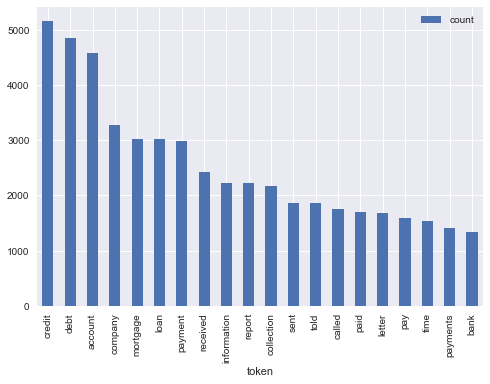

In [192]:
# convert list of tuples into data frame
freq_df = pd.DataFrame.from_records(counter_token.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
freq_df.plot(kind='bar', x='token');

In [193]:
#wordcloud
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def wordcloud(counter):
    """A small wordloud wrapper"""
    wc = WordCloud(width=1200, height=800, 
                   background_color="white", 
                   max_words=200) 
    wc.generate_from_frequencies(counter_token)

    # Plot
    fig=plt.figure(figsize=(6, 4))
    plt.title('Tokens worldcloud after stopwords removal')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    

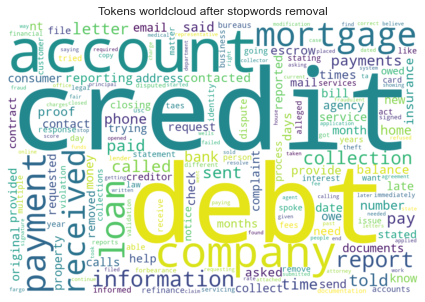

In [194]:
#wordcloud after tokenization and stopword removal
wordcloud(counter_token)

### Text Normalization

In [195]:
import nltk
from nltk.stem.porter import *

#### Stemming

In [196]:
stemmer = PorterStemmer()
#new column with stemmed text
complaints['narrative_stemmed']=complaints['narrative_nostopwords'].apply(lambda x: [stemmer.stem(y) for y in x])

In [197]:
#all stemmed tokens
tokens_stemmed = complaints.narrative_stemmed.sum()

In [198]:
#count stemmed tokens
counter_stemmed = Counter(tokens_stemmed)
counter_stemmed.most_common(20)

[('credit', 5251),
 ('account', 5133),
 ('debt', 5028),
 ('payment', 4389),
 ('report', 4361),
 ('collect', 3576),
 ('compani', 3470),
 ('loan', 3273),
 ('receiv', 3203),
 ('mortgag', 3093),
 ('call', 2824),
 ('inform', 2803),
 ('time', 2632),
 ('pay', 2017),
 ('letter', 2010),
 ('request', 1994),
 ('contact', 1971),
 ('servic', 1969),
 ('sent', 1864),
 ('told', 1863)]

In [199]:
#define wordcloud for stemmed tokens
def wordcloud1(counter):
    """A small wordloud wrapper"""
    wc = WordCloud(width=1200, height=800, 
                   background_color="white", 
                   max_words=200) 
    wc.generate_from_frequencies(counter)

    # Plot
    fig=plt.figure(figsize=(6, 4))
    plt.title('Tokens worldcloud after stemming')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    

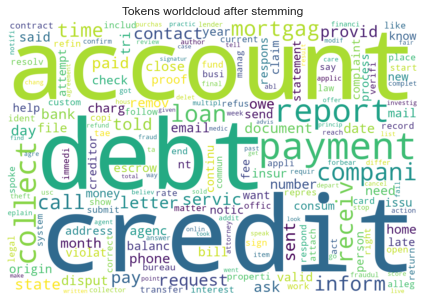

In [200]:
wordcloud1(counter_stemmed)

#### Lemmitization

In [201]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 

#function to lemmitize
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Anupama\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [202]:
#new columns with lemmitized tokens
complaints['narrative_lemmatized']=complaints['narrative_nostopwords'].apply(lemmatize_text)

### Standarise Words

In [203]:
#standardise words
dico = {}
dico1 = open('dico1.txt', 'rb')
for word in dico1:
    word = word.decode('utf8')
    word = word.split()
    dico[word[1]] = word[3]
dico1.close()
dico2 = open('dico2.txt', 'rb')
for word in dico2:
    word = word.decode('utf8')
    word = word.split()
    dico[word[0]] = word[1]
dico2.close()
dico3 = open('dico3.txt', 'rb')
for word in dico3:
    word = word.decode('utf8')
    word = word.split()
    dico[word[0]] = word[1]
dico3.close()

In [204]:
def txt_std(txt):
   # print(type(txt))
   # print(len(txt))
    for i in range(len(txt)):
        if txt[i] in dico.keys():
            txt[i] = dico[txt[i]]     
    #return ' '.join(txt)
    return txt


In [205]:
complaints['narrative_lemmatized'] = complaints['narrative_lemmatized'].apply(txt_std)

In [206]:
#all lemmatized tokens
tokens_lemmatized_debt = complaints[complaints['product']=='Debt collection'].narrative_lemmatized.sum()
counter_lemmatized_debt = Counter(tokens_lemmatized_debt)
counter_lemmatized_debt.most_common()

[('debt', 4940),
 ('credit', 4381),
 ('account', 3892),
 ('collection', 2640),
 ('report', 2400),
 ('company', 2310),
 ('information', 1718),
 ('letter', 1448),
 ('received', 1419),
 ('time', 1189),
 ('sent', 1169),
 ('payment', 1138),
 ('agency', 1010),
 ('called', 957),
 ('reporting', 923),
 ('told', 888),
 ('service', 858),
 ('number', 856),
 ('proof', 815),
 ('pay', 808),
 ('paid', 808),
 ('phone', 754),
 ('bill', 728),
 ('creditor', 723),
 ('day', 704),
 ('owe', 689),
 ('consumer', 677),
 ('provide', 669),
 ('collect', 652),
 ('original', 641),
 ('said', 634),
 ('bureau', 614),
 ('balance', 612),
 ('dispute', 586),
 ('reported', 579),
 ('contacted', 577),
 ('address', 565),
 ('charge', 550),
 ('use', 548),
 ('violation', 548),
 ('contract', 548),
 ('alleged', 540),
 ('asked', 540),
 ('year', 537),
 ('removed', 535),
 ('contact', 525),
 ('date', 513),
 ('law', 509),
 ('card', 501),
 ('owed', 496),
 ('not', 480),
 ('file', 478),
 ('request', 475),
 ('identity', 473),
 ('bank', 462),

In [207]:
tokens_lemmatized_mort = complaints[complaints['product']=='Mortgage'].narrative_lemmatized.sum()
counter_lemmatized_mort = Counter(tokens_lemmatized_mort)
counter_lemmatized_mort.most_common()

[('payment', 3251),
 ('mortgage', 2988),
 ('loan', 2830),
 ('time', 1343),
 ('account', 1239),
 ('company', 1160),
 ('received', 1038),
 ('told', 975),
 ('escrow', 928),
 ('home', 916),
 ('bank', 914),
 ('month', 910),
 ('paid', 896),
 ('pay', 803),
 ('credit', 798),
 ('called', 797),
 ('sent', 696),
 ('day', 691),
 ('insurance', 657),
 ('gmail', 593),
 ('property', 585),
 ('fee', 565),
 ('letter', 563),
 ('document', 549),
 ('check', 544),
 ('late', 544),
 ('phone', 540),
 ('closing', 535),
 ('statement', 523),
 ('said', 523),
 ('information', 514),
 ('new', 511),
 ('refinance', 508),
 ('to', 493),
 ('year', 490),
 ('taes', 483),
 ('money', 473),
 ('issue', 454),
 ('request', 449),
 ('process', 443),
 ('date', 437),
 ('service', 431),
 ('lender', 426),
 ('customer', 418),
 ('interest', 416),
 ('rate', 416),
 ('forbearance', 415),
 ('asked', 406),
 ('need', 404),
 ('contacted', 404),
 (' ', 400),
 ('servicing', 390),
 ('complaint', 388),
 ('help', 385),
 ('requested', 373),
 ('number',

In [208]:
#wordcloud for lemmatized tokens
def wordcloud2(counter):
    """A small wordloud wrapper"""
    wc = WordCloud(width=1200, height=800, 
                   background_color="white", 
                   max_words=200) 
    wc.generate_from_frequencies(counter)

    # Plot
    fig=plt.figure(figsize=(6, 4))
    plt.title('Tokens worldcloud after lemmatization')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    

#### Wordcloud Debt collection

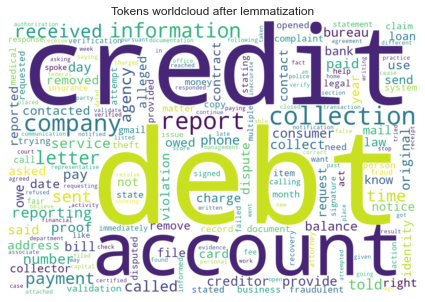

In [209]:
wordcloud2(counter_lemmatized_debt)

#### Wordcloud  Mortgage

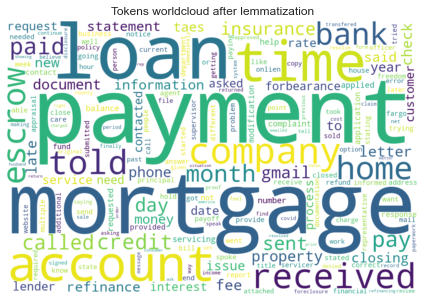

In [210]:
wordcloud2(counter_lemmatized_mort)

#### Repeating words removal

In [211]:
#remove words less than two character
def lc_remove_2(text): 
    return ' '.join(word for word in text if len(word)  > 2)


complaints['narrative_test']=complaints['narrative_lemmatized'].apply(lambda x: lc_remove_2(x))

In [212]:
def unique_list(l):
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    return ulist

def remove_duplicate_string(text):
    return ' '.join(unique_list(text.split()))


complaints['narrative_test']=complaints['narrative_test'].apply(lambda x: remove_duplicate_string(x))




In [213]:
complaints.head()

,product,consumer_complaint_narrative,narrative_expanded,narrative_accented,narrative_entity,narrative_clean,narrative_tokens,narrative_nostopwords,narrative_stemmed,narrative_lemmatized,narrative_test
1,Debt collection,"Bonneville debt collection has called twice ( about a week ago and today XX/XX/2021 ) leaving a message but no detail other than a callback number. I don't have any unpaid debts and when trying to call the number they provide, you just sit on hold in a queue for over an hour. No one answers. Considering this isn't my debt, this is harassment.","Bonneville debt collection has called twice ( about a week ago and today XX/XX/2021 ) leaving a message but no detail other than a callback number. I do not have any unpaid debts and when trying to call the number they provide, you just sit on hold in a queue for over an hour. No one answers. Considering this is not my debt, this is harassment.","Bonneville debt collection has called twice ( about a week ago and today XX/XX/2021 ) leaving a message but no detail other than a callback number. I do not have any unpaid debts and when trying to call the number they provide, you just sit on hold in a queue for over an hour. No one answers. Considering this is not my debt, this is harassment.","debt collection has called twice ( about a week ago and XX / XX/2021 ) leaving a message but no detail other than a callback number . I do not have any unpaid debts and when trying to call the number they provide , you just sit on hold in a queue for over an hour . No answers . Considering this is not my debt , this is harassment .",debt collection has called twice about week ago and leaving message but no detail other than callback number do not have any unpaid debts and when trying to call the number they provide you just sit on hold in queue for over an hour no answers considering this is not my debt this is harassment,"(debt, collection, has, called, twice, about, week, ago, and, leaving, message, but, no, detail, other, than, callback, number, do, not, have, any, unpaid, debts, and, when, trying, to, call, the, number, they, provide, you, just, sit, on, hold, in, queue, for, over, an, hour, no, answers, considering, this, is, not, my, debt, this, is, harassment)","[debt, collection, called, twice, week, ago, leaving, message, detail, callback, number, unpaid, debts, trying, number, provide, sit, hold, queue, hour, answers, considering, debt, harassment]","[debt, collect, call, twice, week, ago, leav, messag, detail, callback, number, unpaid, debt, tri, number, provid, sit, hold, queue, hour, answer, consid, debt, harass]","[debt, collection, called, twice, week, ago, leaving, message, detail, callback, number, unpaid, debt, trying, number, provide, sit, hold, queue, hour, answer, considering, debt, harassment]",debt collection called twice week ago leaving message detail callback number unpaid trying provide sit hold queue hour answer considering harassment
2,Debt collection,"I sent a certified verification of debt letter to the Medical Business Bureau. Unfortunately, the bureau failed to provide any documentation with my signature verifying this debt. I can not pay and will not pay anything that can not be verified. I requested detailed documentaion and the Bureau could not proivde this info.","I sent a certified verification of debt letter to the Medical Business Bureau. Unfortunately, the bureau failed to provide any documentation with my signature verifying this debt. I can not pay and will not pay anything that can not be verified. I requested detailed documentaion and the Bureau could not proivde this info.","I sent a certified verification of debt letter to the Medical Business Bureau. Unfortunately, the bureau failed to provide any documentation with my signature verifying this debt. I can not pay and will not pay anything that can not be verified. I requested detailed documentaion and the Bureau could not proivde this info.","I sent a certified verification of debt letter

### Feature Engineering

In [214]:

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=3,max_df=1.0)
cv_matrix = cv.fit_transform(complaints['narrative_test'])
#cv.vocabulary_
cv_matrix = cv_matrix.toarray()
cv_matrix.shape

(4830, 4143)

In [215]:
# get all unique words in the corpus
cv_vocab = cv.get_feature_names()


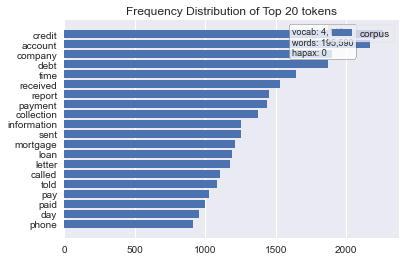

<AxesSubplot:title={'center':'Frequency Distribution of Top 20 tokens'}>

In [216]:
from yellowbrick.text import FreqDistVisualizer

visualizer = FreqDistVisualizer(features=cv_vocab, orient='h',n=20)
visualizer.fit(cv_matrix)
visualizer.show()


In [217]:
# show document feature vectors
pd.DataFrame(cv_matrix, columns=cv_vocab)
#z[z['aargon'] > 0]

first_vector_cv=cv_matrix[0] 
df1 = pd.DataFrame(first_vector_cv, index=cv.get_feature_names(), columns=["CountVectorizer"])
df1_sort=df1.sort_values(by=["CountVectorizer"],ascending=False)
df1_sort


,CountVectorizer
ago,1
sit,1
trying,1
twice,1
queue,1
...,...
etent,0
ethic,0
ethical,0
etort,0


In [218]:
import csv

w = csv.writer(open("output.csv", "w"))
for key, val in cv.vocabulary_.items():
    w.writerow([key, val])

### TF-IDF

In [219]:
from sklearn.feature_extraction.text import TfidfVectorizer 

In [220]:
from sklearn.feature_extraction.text import TfidfVectorizer 
tfidf=TfidfVectorizer(min_df=5,max_df=0.85,use_idf=True) 
tfidf_matrix=tfidf.fit_transform(complaints['narrative_test'])
# get the first vector out (for the first document) 

first_vector_tfidfvectorizer=tfidf_matrix[0] 
df2 = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf.get_feature_names(), columns=["TF-IDF"])
df2_sort=df2.sort_values(by=["TF-IDF"],ascending=False)
df2_sort


,TF-IDF
queue,0.354599
callback,0.335904
sit,0.335904
considering,0.278883
leaving,0.259696
...,...
etent,0.000000
ethic,0.000000
etort,0.000000
etortion,0.000000


In [221]:
merge=df1_sort.join(df2_sort)
merge.head(10)

,CountVectorizer,TF-IDF
ago,1,0.183571
sit,1,0.335904
trying,1,0.149859
twice,1,0.209044
queue,1,0.354599
unpaid,1,0.234601
hour,1,0.192927
debt,1,0.089889
number,1,0.130002
harassment,1,0.246188


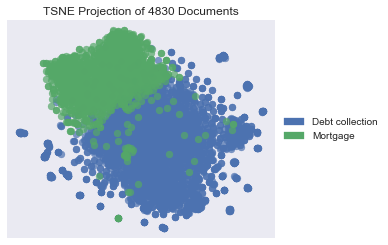

<AxesSubplot:title={'center':'TSNE Projection of 4830 Documents'}>

In [222]:
#corpus = load_hobbies()
#tfidf = TfidfVectorizer()

from yellowbrick.text import TSNEVisualizer
from yellowbrick.datasets import load_hobbies


X =tfidf.fit_transform(complaints['narrative_test'])
y = complaints['product']

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show()

In [223]:
tfidf_matrix=tfidf_matrix.toarray()
tfidf_vocab = tfidf.get_feature_names()
pd.DataFrame(tfidf_matrix, columns=tfidf_vocab)

,abide,ability,able,absence,absent,absolute,absolutely,absurd,abuse,abused,...,wrote,year,yearly,yelled,yelling,yes,yesterday,young,zero,zone
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.125638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.105953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.059304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4826,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4827,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4828,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Word2Vec

In [224]:
complaints['narrative_word2vec']=complaints['narrative_test'].str.split()

In [225]:
from gensim.models import Word2Vec

In [226]:
model=Word2Vec(complaints['narrative_word2vec'],min_count=1,size=10)

In [227]:
words=model.wv.vocab

In [228]:
words

{'debt': <gensim.models.keyedvectors.Vocab at 0x1c3325df668>,
 'collection': <gensim.models.keyedvectors.Vocab at 0x1c3325df6d8>,
 'called': <gensim.models.keyedvectors.Vocab at 0x1c3325dfa20>,
 'twice': <gensim.models.keyedvectors.Vocab at 0x1c34da078d0>,
 'week': <gensim.models.keyedvectors.Vocab at 0x1c31b75e278>,
 'ago': <gensim.models.keyedvectors.Vocab at 0x1c3325968d0>,
 'leaving': <gensim.models.keyedvectors.Vocab at 0x1c332596a20>,
 'message': <gensim.models.keyedvectors.Vocab at 0x1c331dfdb38>,
 'detail': <gensim.models.keyedvectors.Vocab at 0x1c34da03ba8>,
 'callback': <gensim.models.keyedvectors.Vocab at 0x1c34da03160>,
 'number': <gensim.models.keyedvectors.Vocab at 0x1c34da295c0>,
 'unpaid': <gensim.models.keyedvectors.Vocab at 0x1c34da43240>,
 'trying': <gensim.models.keyedvectors.Vocab at 0x1c34da519e8>,
 'provide': <gensim.models.keyedvectors.Vocab at 0x1c34da41b00>,
 'sit': <gensim.models.keyedvectors.Vocab at 0x1c349ca31d0>,
 'hold': <gensim.models.keyedvectors.Vocab

In [229]:
similar=model.wv.most_similar('debt')

In [230]:
similar

[('ross', 0.9804108142852783),
 ('owe', 0.979075014591217),
 ('collector', 0.9748729467391968),
 ('medical', 0.963381826877594),
 ('collect', 0.9560993313789368),
 ('arguably', 0.953076958656311),
 ('sequium', 0.9497406482696533),
 ('agency', 0.9470911622047424),
 ('recovery', 0.9447717070579529),
 ('creditor', 0.9432294368743896)]

In [231]:
#model["debt"]

In [232]:
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(complaints['narrative_test'], complaints['product'],stratify=complaints['product'],random_state=100, 
                                                    test_size=0.25)

In [233]:
print(train_x.shape)
print(valid_x.shape)
print(train_y.shape)
print(valid_y.shape)

(3622,)
(1208,)
(3622,)
(1208,)


In [234]:
from sklearn import preprocessing
enc = preprocessing.LabelEncoder()

train_y = enc.fit_transform(train_y)
valid_y = enc.fit_transform(valid_y)
#enc.classes_
list(enc.inverse_transform([0,1]))

['Debt collection', 'Mortgage']

In [235]:
tfidf=TfidfVectorizer(min_df=5,max_df=0.85,use_idf=True) 
train_x_tfidf=tfidf.fit_transform(train_x)

In [236]:
print(train_x_tfidf[0])

  (0, 398)	0.20820331473077705
  (0, 2280)	0.1829945005395291
  (0, 2434)	0.22033730462030998
  (0, 1895)	0.1335044024538161
  (0, 1739)	0.15287396686276059
  (0, 2362)	0.13882411089267746
  (0, 288)	0.19724332141192039
  (0, 445)	0.29394543527480754
  (0, 253)	0.13219625785717995
  (0, 1622)	0.18188350047402838
  (0, 2478)	0.1857117155346042
  (0, 477)	0.23920730308582397
  (0, 1301)	0.14815757361458373
  (0, 1409)	0.20820331473077705
  (0, 2363)	0.13745786029443494
  (0, 2120)	0.16756708671094944
  (0, 779)	0.26042447413771436
  (0, 469)	0.12802065819203579
  (0, 1848)	0.16459876438959634
  (0, 432)	0.15164245025567044
  (0, 892)	0.17218298400954116
  (0, 1436)	0.2556484938608366
  (0, 2089)	0.12939866827536495
  (0, 338)	0.2885308754108618
  (0, 2436)	0.24232799370570618
  (0, 1894)	0.1265944045159801
  (0, 431)	0.173946260323525


In [237]:
valid_x_tfidf=tfidf.transform(valid_x)

### Classification

#### C-Support Vector Classification

In [238]:
from sklearn import svm


In [239]:
clf_svm=svm.SVC(kernel='linear')

In [240]:
clf_svm.fit(train_x_tfidf,train_y)

SVC(kernel='linear')

In [241]:
print(valid_y[:5])

[0 1 0 0 0]


In [242]:
clf_svm.predict(tfidf.transform(["good previously submitted dispute deletion collection account credit report reported sequim asset solution appeared company called opened fraudulently left physically open including supporting document prove"]))

array([0])

In [243]:
valid_x_tfidf[1]

<1x2741 sparse matrix of type '<class 'numpy.float64'>'
	with 38 stored elements in Compressed Sparse Row format>

In [244]:
valid_x.head()

4167                                      account closed husband job loss covered insurance benefit offered claim company approved processed payment proper work forward information sent letter clearly support mace refusing ecept responsibility meantime credit severely damage review advise
3542         lawyer told assist called customer service shady not know trying hold thin time said need research asked long application assistance stop foreclosure code thing happen soon possible got slilent drag word mouth upload proof apply gmail for promise send letter reviewing qualify
1483    received credit control llc stating outstanding balance stated debt originated company informed disputing paid timely representative solve matter directly called requested mail written documentation validating right pursuant fair collection practice act fdcpa provided home address
4058                                                                              good previously submitted dispute deletion colle

In [245]:
#valid_y[4058]

In [246]:
from sklearn.metrics import accuracy_score

In [247]:
svm_accuracy=clf_svm.score(valid_x_tfidf, valid_y, sample_weight=None)
print ("SVM > Accuracy: ", svm_accuracy)

SVM > Accuracy:  0.9710264900662252


#### LinearSVC

In [248]:
from sklearn.svm import LinearSVC
clf_svc = LinearSVC(C=0.1)
clf_svc.fit(train_x_tfidf,train_y)

LinearSVC(C=0.1)

In [249]:
import sklearn.metrics as metrics
svc_predict = clf_svc.predict(valid_x_tfidf)
svc_accuracy = metrics.accuracy_score(svc_predict, valid_y)
print ("LinearSVC > Accuracy: ", svc_accuracy)



LinearSVC > Accuracy:  0.9693708609271523


In [250]:
from sklearn.metrics import classification_report
print(classification_report(valid_y, svc_predict,target_names=complaints['product'].unique()))

                 precision    recall  f1-score   support

Debt collection       0.97      0.98      0.98       799
       Mortgage       0.96      0.94      0.95       409

       accuracy                           0.97      1208
      macro avg       0.97      0.96      0.97      1208
   weighted avg       0.97      0.97      0.97      1208



In [251]:
from sklearn.naive_bayes import MultinomialNB
clf_nb = MultinomialNB().fit(train_x_tfidf, train_y)

In [252]:
nb_predict = clf_nb.predict(valid_x_tfidf)
nb_accuracy = metrics.accuracy_score(nb_predict, valid_y)
print ("Multinomial Naive Bayes > Accuracy: ", nb_accuracy)


Multinomial Naive Bayes > Accuracy:  0.9503311258278145


In [253]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression()
clf_lr.fit(train_x_tfidf,train_y)
lr_predict = clf_lr.predict(valid_x_tfidf)
lr_accuracy = metrics.accuracy_score(lr_predict, valid_y)
print ("Logistic Regression > Accuracy: ", lr_accuracy)

Logistic Regression > Accuracy:  0.9668874172185431


In [254]:
from sklearn.tree import DecisionTreeClassifier
clf_dec = DecisionTreeClassifier(random_state=0)
clf_dec.fit(train_x_tfidf,train_y)
dec_predict = clf_dec.predict(valid_x_tfidf)
dec_accuracy = metrics.accuracy_score(dec_predict, valid_y)
print ("Decission Tree > Accuracy: ", dec_accuracy)

Decission Tree > Accuracy:  0.9329470198675497


In [255]:
print ("LinearSVC               > Accuracy: ", round(svc_accuracy,2))
print ("Decission Tree          > Accuracy: ", round(dec_accuracy,2))
print ("Logistic Regression     > Accuracy: ", round(lr_accuracy,2))
print ("Multinomial Naive Bayes > Accuracy: ", round(nb_accuracy,2))

LinearSVC               > Accuracy:  0.97
Decission Tree          > Accuracy:  0.93
Logistic Regression     > Accuracy:  0.97
Multinomial Naive Bayes > Accuracy:  0.95


In [256]:
 from sklearn.metrics import f1_score

In [257]:
print("Logistic Regression > f1_score:",f1_score(valid_y, lr_predict,labels=['Debt collection', 'Mortgage']))
print("SVC  >                f1_score:",f1_score(valid_y, svc_predict,labels=['Debt collection', 'Mortgage']))
print("Multinomial NaiveBayes>f1_score: ",f1_score(valid_y, nb_predict,labels=['Debt collection', 'Mortgage']))
print("Decission Tree        > f1_score: ",f1_score(valid_y, dec_predict,labels=['Debt collection', 'Mortgage']))

Logistic Regression > f1_score: 0.9503722084367247
SVC  >                f1_score: 0.9542645241038319
Multinomial NaiveBayes>f1_score:  0.9259259259259259
Decission Tree        > f1_score:  0.8996282527881041


In [258]:
train_y

array([1, 1, 0, ..., 0, 0, 0])

In [259]:
from yellowbrick.classifier import ClassificationReport

classes=['Debt collection','Mortgage']
visualizer_dec = ClassificationReport(clf_dec, classes=classes, support=True)

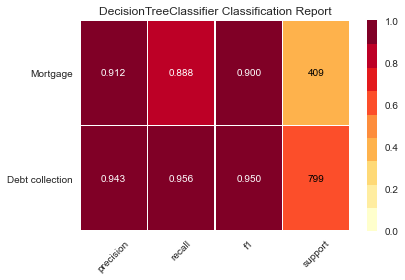

<AxesSubplot:title={'center':'DecisionTreeClassifier Classification Report'}>

In [260]:
visualizer_dec.fit(train_x_tfidf, train_y)        # Fit the visualizer and the model
visualizer_dec.score(valid_x_tfidf, valid_y)        # Evaluate the model on the test data
visualizer_dec.show()    

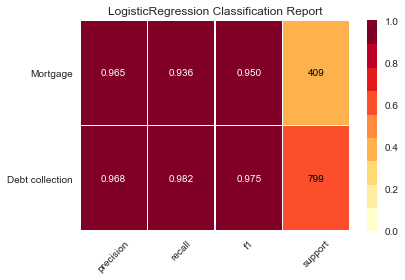

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [261]:
visualizer_lr = ClassificationReport(clf_lr, classes=classes, support=True)
visualizer_lr.fit(train_x_tfidf, train_y)        # Fit the visualizer and the model
visualizer_lr.score(valid_x_tfidf, valid_y)        # Evaluate the model on the test data
visualizer_lr.show()  

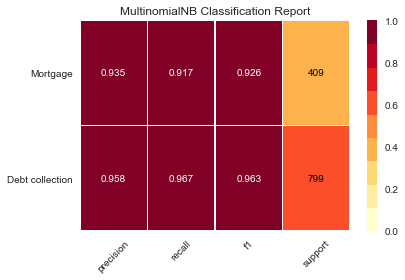

<AxesSubplot:title={'center':'MultinomialNB Classification Report'}>

In [262]:
visualizer_nb = ClassificationReport(clf_nb, classes=classes, support=True)
visualizer_nb.fit(train_x_tfidf, train_y)        # Fit the visualizer and the model
visualizer_nb.score(valid_x_tfidf, valid_y)        # Evaluate the model on the test data
visualizer_nb.show()  

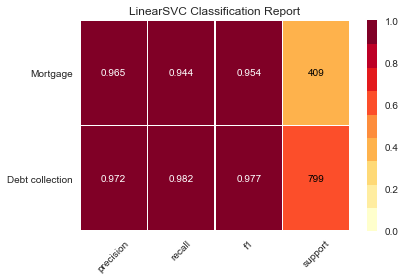

<AxesSubplot:title={'center':'LinearSVC Classification Report'}>

In [263]:
visualizer_svc = ClassificationReport(clf_svc, classes=classes, support=True)
visualizer_svc.fit(train_x_tfidf, train_y)        # Fit the visualizer and the model
visualizer_svc.score(valid_x_tfidf, valid_y)        # Evaluate the model on the test data
visualizer_svc.show()  

#### Local Interpretable Model-Agnostic Explanations

In [264]:
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [265]:
valid_x.index[0] #4167 -debt collection
valid_x[4167]

'account closed husband job loss covered insurance benefit offered claim company approved processed payment proper work forward information sent letter clearly support mace refusing ecept responsibility meantime credit severely damage review advise'

In [266]:
idx = valid_x.index[0]
c = make_pipeline(tfidf, clf_lr)
class_names = ['Debt Collection', 'Mortgage']
explainer = LimeTextExplainer(class_names = class_names)
exp = explainer.explain_instance(valid_x[4167], c.predict_proba, num_features = 10)

print("Narrative: \n", valid_x[4167])
print("Probability (0) =", c.predict_proba([valid_x[4167]])[0, 1])
print("Probability (1) =", c.predict_proba([valid_x[4167]])[0, 0])
print("True Class is:", class_names[valid_y[0]])

C:\Users\Anupama\Anaconda3\envs\deep\lib\site-packages\lime\lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Narrative: 
 account closed husband job loss covered insurance benefit offered claim company approved processed payment proper work forward information sent letter clearly support mace refusing ecept responsibility meantime credit severely damage review advise
Probability (0) = 0.3285833559284456
Probability (1) = 0.6714166440715543
True Class is: Debt Collection


In [267]:
exp.as_list()

[('credit', -0.0661345098377433),
 ('payment', 0.05809454471211315),
 ('processed', 0.048799380828475195),
 ('account', -0.04474294218810398),
 ('approved', 0.043477502111461536),
 ('insurance', 0.03800094802586751),
 ('claim', -0.03538824327354215),
 ('information', -0.03156452750702832),
 ('review', 0.028071721047256668),
 ('husband', 0.026963077190222326)]

In [268]:
exp.show_in_notebook(text=valid_x[4167], labels=(1,))